# Emoji Polysemy Project

## Data Wrangling, Processing, and Analysis

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
import emoji
from tqdm import tqdm
from collections import defaultdict


In [13]:
df = pd.read_csv("tweets_data.csv", parse_dates=["created_at"])
df.head()

,author_id,created_at,geo,tweet_id,like_count,quote_count,reply_count,retweet_count,text
0,431948312,2017-01-30 23:55:49+00:00,,826217383039729664,0.0,0.0,0.0,0.0,We have the power👊💥😂💚 https://t.co/8en3JNwkny
1,418718492,2017-05-30 23:56:15+00:00,,869704038048202752,0.0,0.0,0.0,0.0,Sleep would be nice but Maiyahs cosies are bet...
2,340099697,2016-10-30 23:57:35+00:00,{'place_id': '31fd9d42c71e7afa'},792878143887605760,1.0,0.0,0.0,0.0,Lynn mad af cause Eric ate her chocolate chip ...
3,1249825087525728257,2020-10-30 23:59:39+00:00,,1322327339200630784,0.0,0.0,0.0,0.0,@KaileGedye text me cus I haven’t 🤣
4,205097885,2018-03-30 23:54:29+00:00,,979869505622069248,0.0,0.0,1.0,0.0,@juanlabia @Skelebird Yea but i feel like you ...


In [14]:
df.loc[:, "year"] = df.created_at.dt.year

In [15]:
df.year.value_counts().sort_index()

2014    65333
2015    65340
2016    65236
2017    65034
2018    64943
2019    64537
2020    63403
2021    63812
Name: year, dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517638 entries, 0 to 517637
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   author_id      517638 non-null  int64              
 1   created_at     517638 non-null  datetime64[ns, UTC]
 2   geo            517638 non-null  object             
 3   tweet_id       517638 non-null  int64              
 4   like_count     517638 non-null  float64            
 5   quote_count    517638 non-null  float64            
 6   reply_count    517638 non-null  float64            
 7   retweet_count  517638 non-null  float64            
 8   text           517638 non-null  object             
 9   year           517638 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(3), object(2)
memory usage: 39.5+ MB


Dataset ranges from 1/30/14 to 12/30/21

In [18]:
df.created_at.describe()

/var/folders/lj/w4hy005d5vx9qy3lrwz0xdl80000gn/T/ipykernel_35886/1951218934.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.created_at.describe()


count                        517638
unique                        20669
top       2014-06-29 23:59:25+00:00
freq                            120
first     2014-01-30 23:57:31+00:00
last      2021-12-30 23:59:59+00:00
Name: created_at, dtype: object

In [19]:
cv = CountVectorizer(analyzer="char", binary=True)

In [20]:
cv.fit(df.text.tolist())

CountVectorizer(analyzer='char', binary=True)

In [21]:
features = cv.get_feature_names()

In [22]:
feature_emojis = [i for i in features if i in emoji.UNICODE_EMOJI_ENGLISH]
len(feature_emojis)

1227

In [23]:
emoji_dtm = cv.transform(df.text.tolist())
emoji_dtm = pd.DataFrame(index = df.tweet_id, data = emoji_dtm.toarray(), columns=features).astype('int16')

In [24]:
emoji_dtm = emoji_dtm[feature_emojis]

In [25]:
emoji_dtm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517638 entries, 826217383039729664 to 1090761093826265216
Columns: 1227 entries, © to 🫖
dtypes: int16(1227)
memory usage: 1.2 GB


In [26]:
emoji_freq = emoji_dtm.sum()

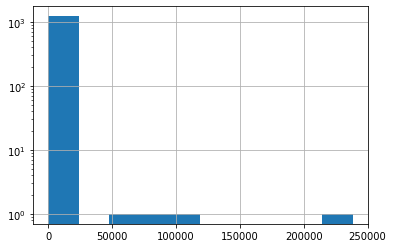

In [27]:
emoji_freq.hist()
plt.yscale("log")

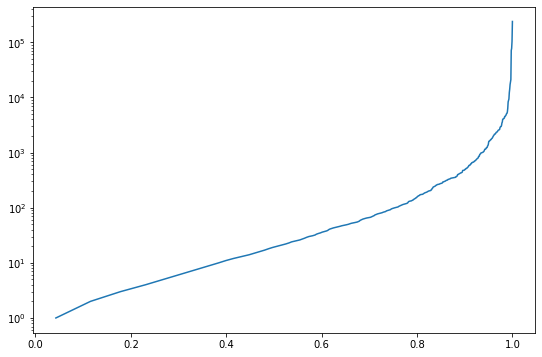

In [28]:
plt.figure(figsize=(9, 6))
plt.plot(emoji_freq.sort_values().rank(pct =True), emoji_freq.sort_values())
plt.yscale("log")

Only 50 emojis have been used in at least 2000 tweets

In [31]:
(emoji_freq>=2000).sum()

50

In [32]:
top_emojis = emoji_freq[emoji_freq>=2000].index

In [33]:
top_emojis_dtm = emoji_dtm[top_emojis]

Filter out tweet ids that don't feature any of the top 50 emojis

In [34]:
top_emojis_dtm = top_emojis_dtm[top_emojis_dtm.sum(axis = 1) > 0]

In [35]:
top_emojis_dtm.shape

(517501, 50)

We've significantly narrowed down our pool of emojis to to analyze. 

I want to see if some emojis that do not appear at all or infrequently for each of the eight years in the dataset.

In [37]:
year = df.year.set_axis(df.tweet_id)

In [38]:
emojis_year = pd.concat([top_emojis_dtm, year], axis = 1, join = "inner")
emojis_year.head()

,☺,♀,♂,✌,✨,❤,🎉,🏻,🏼,🏽,...,🙄,🙈,🙌,🙏,🤣,🤦,🤷,🥰,🥺,year
tweet_id,,,,,,,,,,,,,,,,,,,,,
826217383039729664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2017
869704038048202752,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2017
792878143887605760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016
1322327339200630784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2020
979869505622069248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2018


In [39]:
yearly_emoji_sums = emojis_year.groupby("year").sum()
yearly_emoji_sums

,☺,♀,♂,✌,✨,❤,🎉,🏻,🏼,🏽,...,😳,🙄,🙈,🙌,🙏,🤣,🤦,🤷,🥰,🥺
year,,,,,,,,,,,,,,,,,,,,,
2014,741.0,0.0,0.0,474.0,1699.0,8110.0,355.0,0.0,0.0,0.0,...,696.0,0.0,1047.0,1411.0,3865.0,0.0,0.0,0.0,0.0,0.0
2015,581.0,0.0,0.0,385.0,2774.0,11655.0,450.0,459.0,623.0,458.0,...,314.0,105.0,781.0,1061.0,3569.0,0.0,0.0,0.0,0.0,0.0
2016,327.0,23.0,16.0,249.0,1854.0,9879.0,389.0,654.0,752.0,753.0,...,218.0,848.0,356.0,614.0,1307.0,46.0,13.0,8.0,0.0,0.0
2017,200.0,1088.0,411.0,205.0,2110.0,10199.0,336.0,782.0,764.0,1237.0,...,164.0,519.0,258.0,594.0,1740.0,1245.0,775.0,668.0,0.0,0.0
2018,186.0,1205.0,621.0,196.0,2052.0,10434.0,252.0,836.0,668.0,1085.0,...,131.0,397.0,163.0,509.0,2056.0,2863.0,879.0,763.0,354.0,77.0
2019,186.0,871.0,575.0,158.0,1879.0,9156.0,182.0,642.0,543.0,847.0,...,170.0,283.0,139.0,375.0,2269.0,3828.0,691.0,571.0,2227.0,3073.0
2020,161.0,585.0,359.0,408.0,2857.0,9073.0,182.0,643.0,403.0,610.0,...,206.0,216.0,114.0,286.0,2710.0,4168.0,434.0,332.0,2578.0,6134.0
2021,206.0,388.0,326.0,152.0,3596.0,8968.0,207.0,616.0,321.0,463.0,...,199.0,172.0,102.0,290.0,3517.0,4950.0,315.0,232.0,3114.0,4783.0


Retain the tweets that feature of the top 50 emojis.

In [40]:
df = df[df.tweet_id.isin(top_emojis_dtm.index)]
df.head()

,author_id,created_at,geo,tweet_id,like_count,quote_count,reply_count,retweet_count,text,year
0,431948312,2017-01-30 23:55:49+00:00,,826217383039729664,0.0,0.0,0.0,0.0,We have the power👊💥😂💚 https://t.co/8en3JNwkny,2017
1,418718492,2017-05-30 23:56:15+00:00,,869704038048202752,0.0,0.0,0.0,0.0,Sleep would be nice but Maiyahs cosies are bet...,2017
2,340099697,2016-10-30 23:57:35+00:00,{'place_id': '31fd9d42c71e7afa'},792878143887605760,1.0,0.0,0.0,0.0,Lynn mad af cause Eric ate her chocolate chip ...,2016
3,1249825087525728257,2020-10-30 23:59:39+00:00,,1322327339200630784,0.0,0.0,0.0,0.0,@KaileGedye text me cus I haven’t 🤣,2020
4,205097885,2018-03-30 23:54:29+00:00,,979869505622069248,0.0,0.0,1.0,0.0,@juanlabia @Skelebird Yea but i feel like you ...,2018


Load the Bertweet tokenizer and model.

In [42]:
# Load the AutoTokenizer with a normalization mode if the input Tweet is raw
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True, use_fast=False)
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Not all emojis will work for this analysis because some are not recognized by bertweet or are tokenized into subword tokens.

Therefor I need to filter those emojis out.

In [59]:
emoji_ids = []
for e in top_emojis:
    e_code = emoji.EMOJI_DATA[e]['en']
    try:
        token_id = vocab[e_code]
        emoji_ids.append(token_id)
    except KeyError:
        print("{} is an unknown token or is tokenized into subwords".format(e))

🏼 is an unknown token or is tokenized into subwords
🏾 is an unknown token or is tokenized into subwords
🥰 is an unknown token or is tokenized into subwords


### Emoji embedding ETL

I demonstrate my process with this example tweet below.

In [58]:
line = df.text.iloc[130700]
line

'@SherriTeri_FR goodnight rest well sweet dreams &amp; enjoy tomorrow❤️😃✌️😘'

1. Encode the raw tweet text, basically convert the texts into token ids.

In [63]:
tokenizer.tokenize(line)

['@USER',
 'goodnight',
 'rest',
 'well',
 'sweet',
 'dreams',
 '&',
 'enjoy',
 'tomorrow',
 ':red_heart:',
 ':grinning_face_with_big_eyes:',
 ':victory_hand:',
 ':face_blowing_a_kiss:']

In [61]:
token_ids = np.array(tokenizer.encode(line))
token_ids

array([   0,    5, 4515,  765,  182, 1005, 1516,   55,  982,  266,  280,
       3475, 1672,  722,    2])

2. Determine which tokens are emojis. This step returns a boolean mask where True means emoji token and False means not.

In [62]:
emoji_bools = np.isin(token_ids, emoji_ids)
emoji_bools

array([False, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True, False])

3. Grab just the emoji token ids.

In [66]:
emoji_tokens = token_ids[emoji_bools]
emoji_tokens

array([ 280, 1672,  722])

4. Generate embeddings from the encoded text using bertweet

In [67]:
with torch.no_grad():
    embeddings = bertweet(torch.tensor([token_ids]))[0].numpy()[0]

/var/folders/lj/w4hy005d5vx9qy3lrwz0xdl80000gn/T/ipykernel_35886/2425958554.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  embeddings = bertweet(torch.tensor([token_ids]))[0].numpy()[0]


In [69]:
embeddings.shape

(15, 768)

5. Use the emoji boolean mask to grab the emoji embeddings.

In [70]:
emoji_embeddings = embeddings[emoji_bools]
emoji_embeddings

array([[-0.66483027,  0.2755706 ,  0.17657888, ...,  0.19420546,
        -0.41890293,  0.11247531],
       [-0.7519687 ,  0.36873898,  0.0111955 , ...,  0.19940768,
        -0.09566376,  0.05310378],
       [-0.6289631 ,  0.26437992,  0.02097072, ...,  0.1942093 ,
        -0.26012963,  0.0428402 ]], dtype=float32)

In [71]:
emoji_embeddings.shape

(3, 768)

6. The next step involves organizing this data in a way that keeps track of the emoji ids, embeddings,and the tweet ids.

### The full process

This is the full pipeline where I iterate over each tweet and perform the ETL step shown above. 

In [80]:
text_dict = iter(df.set_index("tweet_id").text.to_dict().items())

The `vectors` dictionary where I will store the results of the ETL process. 

The keys are emoji ids and their values are defaultdicts who keys are tweet ids and values is a list of that emoji's embeddings in that tweet.

The structure looks like this:


```
{
   emoji_id: {
      tweet_id: [
         embedding,
         embedding,
         "..."
      ]
   }
}
```

In [74]:
vectors = {i:defaultdict(list) for i in emoji_ids}

In [83]:
n_tweets = df.tweet_id.nunique()
for iD, text in tqdm(text_dict, total = n_tweets):
    token_ids = np.array(tokenizer.encode(text,truncation=True))
    emoji_bools = np.isin(token_ids, emoji_ids)
    emoji_tokens = token_ids[emoji_bools]
    
    with torch.no_grad():
        embeddings = bertweet(torch.tensor([token_ids]))[0].numpy()[0]
        
    emoji_embeddings = embeddings[emoji_bools]
    
    for i, e in enumerate(emoji_tokens):
        vectors[e][iD].append(emoji_embeddings[i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 517500/517501 [10:48:38<00:00, 13.30it/s]


In [84]:
vector_dataframes = []
for ei, emoji_data in vectors.items():
    vector_df = defaultdict(list)
    for iD, embeds in emoji_data.items():
        for emb in embeds:
            vector_df["tweet_id"].append(iD)
            vector_df["embedding"].append(emb)
    vector_df = pd.DataFrame(vector_df)
    vector_df["emoji_id"] = ei
    vector_dataframes.append(vector_df)

In [85]:
vector_dataframes = pd.concat(vector_dataframes)

In [86]:
vector_dataframes.to_pickle("emoji_vectors_data.pkl")